# Galaxy Lensing Classification Using ResNet18

This notebook demonstrates a pipeline for classifying galaxy images (lensed and non-lensed) using a modified ResNet18 model. The dataset consists of `.npy` files representing images, which are converted into `.png` format for use with PyTorch's `ImageFolder`. The training process uses transfer learning and data augmentation to enhance performance. 

## Steps in the Pipeline



### 1. **Data Augmentation and Transformations**
- Training transformations include:
  - Grayscale conversion
  - Random affine transformations (rotations and translations)
  - Resizing to `(150, 150)`
  - Conversion to PyTorch tensors
- Validation transformations include only grayscale conversion, resizing, and tensor conversion.

### 2. **Model Architecture**
- A pretrained ResNet18 model is used, modified to handle single-channel grayscale images:
  - The first convolutional layer is adjusted to accept one channel instead of three.
  - The final fully connected layer is replaced with a custom classification head to handle three output classes.

### 3. **Training Loop**
- **Optimizer**: Adam optimizer with a learning rate of `1e-4`.
- **Loss Function**: Cross-Entropy Loss.
- **Scheduler**: ReduceLROnPlateau to reduce the learning rate when validation AUC stagnates.
- **Validation Metrics**:
  - Accuracy
  - AUC (Area Under the Curve) for multi-class classification using `roc_auc_score`.

### 4. **Model Evaluation**
- The `evaluate_model` function calculates:
  - Accuracy by comparing predicted and true labels.
  - AUC for multi-class classification using the softmax probabilities.
- The best model based on validation AUC is saved to disk as `best_model.pth`.

## Dependencies
- Python libraries: `torch`, `torchvision`, `numpy`, `PIL`, `matplotlib`, `sklearn`, `tqdm`



In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

### **Exploratory data Analysis**

In [2]:
import os
print(os.listdir("../input/dataset/train"))

['no', 'vort', 'sphere']


In [3]:
a=np.load('../input/dataset/train/no/1.npy')
print(a)

[[[0.0130039  0.00910273 0.01820546 ... 0.00910273 0.01560468 0.01170351]
  [0.01690507 0.01690507 0.01950585 ... 0.0130039  0.01040312 0.01560468]
  [0.00910273 0.00910273 0.01690507 ... 0.0130039  0.01430429 0.00780234]
  ...
  [0.01820546 0.01560468 0.00650195 ... 0.00910273 0.01820546 0.01040312]
  [0.01950585 0.00910273 0.01170351 ... 0.00650195 0.00910273 0.00780234]
  [0.02080624 0.01430429 0.01040312 ... 0.00910273 0.01430429 0.01040312]]]


### **Visualizing the data**
- The dataset consists of `.npy` files stored in directories categorized as `train` and `val`, with subcategories for each class (`no`, `sphere`, `vort`).
- We'll visualize the data for better understanding of the images

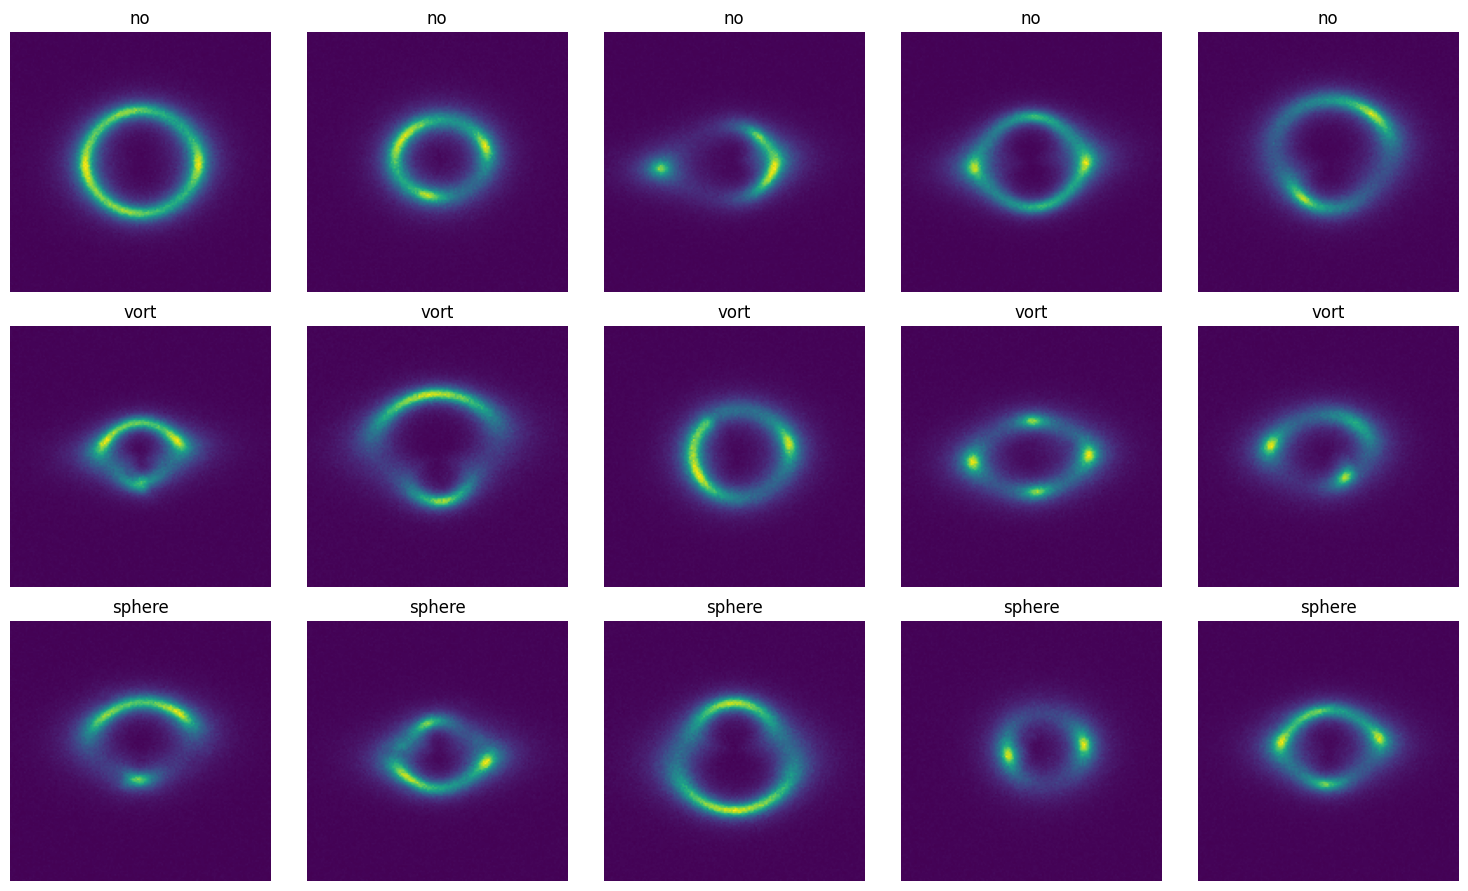

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

train_folder_path = '../input/dataset/train/'

categories = os.listdir(train_folder_path)

num_images = 5

fig, axes = plt.subplots(len(categories), num_images, figsize=(15, len(categories) * 3))

for i, category in enumerate(categories):
    category_path = os.path.join(train_folder_path, category)
    
    npy_files = [f for f in os.listdir(category_path) if f.endswith('.npy')]
    
    for j in range(min(num_images, len(npy_files))):
        np_array = np.load(os.path.join(category_path, npy_files[j]))
        
        np_array = np_array * 255.0
        np_array = np_array.astype(np.uint8)
        np_array = np_array.squeeze(axis=0)  

        image = Image.fromarray(np_array)
        
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{category}")

# Show the plot
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt

file_path = '../input/dataset/train/no/1.npy'

np_array = np.load(file_path)
print(np_array)
print(np_array.shape)

[[[0.0130039  0.00910273 0.01820546 ... 0.00910273 0.01560468 0.01170351]
  [0.01690507 0.01690507 0.01950585 ... 0.0130039  0.01040312 0.01560468]
  [0.00910273 0.00910273 0.01690507 ... 0.0130039  0.01430429 0.00780234]
  ...
  [0.01820546 0.01560468 0.00650195 ... 0.00910273 0.01820546 0.01040312]
  [0.01950585 0.00910273 0.01170351 ... 0.00650195 0.00910273 0.00780234]
  [0.02080624 0.01430429 0.01040312 ... 0.00910273 0.01430429 0.01040312]]]
(1, 150, 150)


In [6]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import os
import torch
from PIL import Image

class Config:
    num_epochs = 50
    batch_size = 128
    lr = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Converting the numpy files to pngs**

In [7]:
source_dir = '../input/dataset' 

destination_dir = '/kaggle/working/dataset' 

os.makedirs(destination_dir, exist_ok=True)

classes = ['no', 'sphere', 'vort']

def convert_npy_to_png(src_file, dest_file):
    np_array = np.load(src_file)
    np_array = np.squeeze(np_array)
    img = Image.fromarray(np.uint8(np_array * 255)) 
    img.save(dest_file)

for phase in ['train', 'val']:
    for class_name in classes:
        class_src_dir = os.path.join(source_dir, phase, class_name)
        class_dest_dir = os.path.join(destination_dir, phase, class_name)
        
        os.makedirs(class_dest_dir, exist_ok=True)
        
        for file_name in os.listdir(class_src_dir):
            if file_name.endswith('.npy'):
                src_file = os.path.join(class_src_dir, file_name)
                dest_file = os.path.join(class_dest_dir, file_name.replace('.npy', '.png'))
                
                convert_npy_to_png(src_file, dest_file)

print("Conversion complete!")


Conversion complete!


### - **Data Transformations**:
  - For training data, images are converted to grayscale, randomly augmented (rotations and translations), resized to 150x150, and converted to tensors.
  - Validation data undergoes grayscale conversion, resizing, and tensor conversion without augmentations.



In [8]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from sklearn.metrics import roc_auc_score

import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=(0, 180), translate=(0.2, 0.2)),
    transforms.Resize((150, 150)),
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
])

### - **Dataset Preparation**:
  - The training images are loaded and split into 90% for training and 10% for validation.
  - A separate validation dataset is also loaded.

In [9]:
train_dir = "/kaggle/working/dataset/train"
val_dir = "/kaggle/working/dataset/val"

full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset_from_train = random_split(full_train_dataset, [train_size, val_size])

val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
val_loader_from_train = DataLoader(val_dataset_from_train, batch_size=128, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, pin_memory=True)

### **Model Architecture**
- A pretrained ResNet18 model is used, modified to handle single-channel grayscale images:
  - The first convolutional layer is adjusted to accept one channel instead of three.
  - The final fully connected layer is replaced with a custom classification head to handle three output classes.

In [10]:
model = models.resnet18(pretrained=True)

model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 3)
)

model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **Training Loop**
- **Optimizer**: Adam optimizer with a learning rate of `1e-4`.
- **Loss Function**: Cross-Entropy Loss.
- **Scheduler**: ReduceLROnPlateau to reduce the learning rate when validation AUC stagnates.
- **Validation Metrics**:
  - Accuracy
  - AUC (Area Under the Curve) for multi-class classification using `roc_auc_score`.

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss

# Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=4, min_lr=1e-5, verbose=True)

# Training loop
def train_model(num_epochs=50):
    max_auc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Update the weights
            optimizer.step()

            running_loss += loss.item()

        # After training epoch, evaluate on validation set
        val_acc, val_auc = evaluate_model(val_loader_from_train)
        scheduler.step(val_auc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, '
              f'Validation Accuracy: {val_acc:.4f}, Validation AUC: {val_auc:.4f}')

        # Save the best model based on validation AUC
        if val_auc > max_auc:
            max_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### **Model Evaluation**
- The `evaluate_model` function calculates:
  - Accuracy by comparing predicted and true labels.
  - AUC for multi-class classification using the softmax probabilities.
- The best model based on validation AUC is saved to disk as `best_model.pth`.

In [12]:
def evaluate_model(loader):
    model.eval()
    y_true, y_pred = [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    acc = correct / total

    # Calculate AUC
    y_true_one_hot = torch.nn.functional.one_hot(torch.tensor(y_true), num_classes=3)
    auc = roc_auc_score(y_true_one_hot, torch.softmax(torch.tensor(y_pred), dim=1), multi_class='ovr')

    return acc, auc

In [13]:
# Start training
train_model()

<ipython-input-12-15931ae9392e>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  auc = roc_auc_score(y_true_one_hot, torch.softmax(torch.tensor(y_pred), dim=1), multi_class='ovr')


Epoch 1/50, Loss: 1.0989, Validation Accuracy: 0.3407, Validation AUC: 0.5264
Epoch 2/50, Loss: 1.0472, Validation Accuracy: 0.4650, Validation AUC: 0.6816
Epoch 3/50, Loss: 0.9118, Validation Accuracy: 0.4820, Validation AUC: 0.7281
Epoch 4/50, Loss: 0.7711, Validation Accuracy: 0.6330, Validation AUC: 0.8243
Epoch 5/50, Loss: 0.6497, Validation Accuracy: 0.7337, Validation AUC: 0.8918
Epoch 6/50, Loss: 0.5652, Validation Accuracy: 0.7337, Validation AUC: 0.9040
Epoch 7/50, Loss: 0.5127, Validation Accuracy: 0.7853, Validation AUC: 0.9261
Epoch 8/50, Loss: 0.4752, Validation Accuracy: 0.7950, Validation AUC: 0.9308
Epoch 9/50, Loss: 0.4421, Validation Accuracy: 0.8020, Validation AUC: 0.9412
Epoch 10/50, Loss: 0.4105, Validation Accuracy: 0.8117, Validation AUC: 0.9492
Epoch 11/50, Loss: 0.3921, Validation Accuracy: 0.8350, Validation AUC: 0.9535
Epoch 12/50, Loss: 0.3718, Validation Accuracy: 0.8420, Validation AUC: 0.9541
Epoch 13/50, Loss: 0.3634, Validation Accuracy: 0.8500, Valid

In [14]:
# Load the best model and evaluate
model.load_state_dict(torch.load("best_model.pth"))
test_acc, test_auc = evaluate_model(val_loader)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")


<ipython-input-14-93409e6d8853>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 0.9116, Test AUC: 0.9874


In [15]:
class_mapping = full_train_dataset.class_to_idx

print("Class to Index Mapping:", class_mapping)

index_to_class = {v: k for k, v in class_mapping.items()}
print("Index to Class Mapping:", index_to_class)


Class to Index Mapping: {'no': 0, 'sphere': 1, 'vort': 2}
Index to Class Mapping: {0: 'no', 1: 'sphere', 2: 'vort'}


### - **ROC curve Plotting**:


In [16]:
def plot_roc_curve_with_class_names(model, loader, index_to_class):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    plt.figure(figsize=(10, 7))
    for class_idx, class_name in index_to_class.items():
        y_true_binary = (y_true == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(y_true_binary, y_score[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

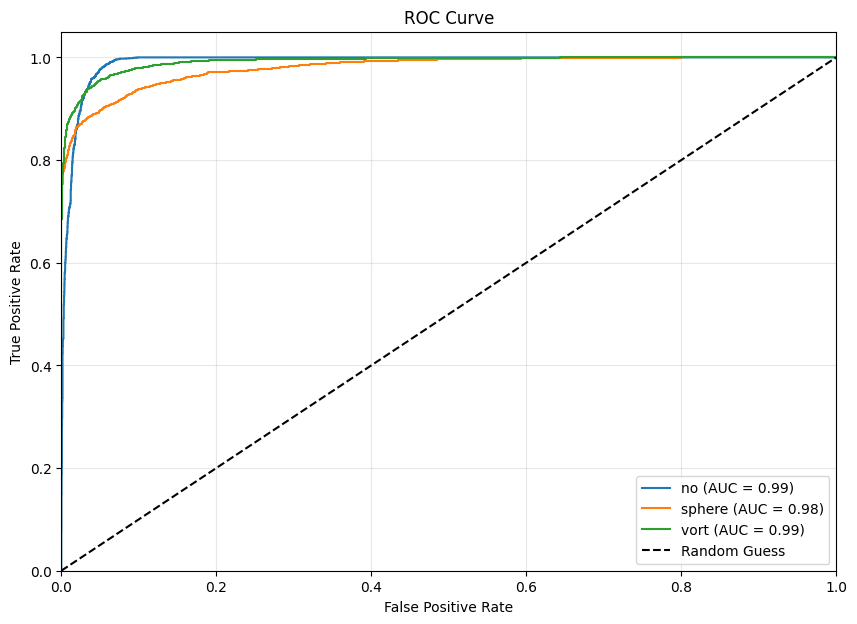

In [19]:
from sklearn.metrics import auc
index_to_class = {0: 'no', 1: 'sphere', 2: 'vort'}

plot_roc_curve_with_class_names(model, val_loader, index_to_class)